In [1]:
import scanpy as sc
import graph_tool.all as gt
import scnsbm
import pandas as pd
import anndata
import mygene
import pickle
import scipy.stats
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
markers = pd.read_excel('../benchmarking_data/41587_2020_469_MOESM4_ESM.xlsx', skiprows=2)
cols = markers.columns
cols = [x.replace(' ', '_') for x in cols]
cols = [x.replace('+', '') for x in cols]
cols = [x.replace('-', '_') for x in cols]
cols = [x.replace('_cell', '') for x in cols]
markers.columns = cols

In [55]:
tdata = pd.read_table("../benchmarking_data/GSE133535_10X2x5Kcell250Kreads_human_exp_mat.tsv.gz", compression='gzip')
adata = anndata.AnnData(tdata.T)

In [56]:
metadata = pd.read_table("../benchmarking_data/GSE133535_10X2x5Kcell250Kreads_human_metada.tsv.gz", compression='gzip')

In [57]:
hca_annot = pd.read_table("../benchmarking_data/HCA_annotations.txt")

cells = [x for x in hca_annot.query('batch == "Chromium"').index if x in adata.obs_names]

adata = adata[cells]

adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
sc.pp.filter_genes(adata, min_cells=5)



Trying to set attribute `.obs` of view, copying.


filtered out 10974 genes that are detected in less than 5 cells


In [58]:
mg = mygene.MyGeneInfo()

In [59]:

ensgenes = [x.split('.')[0] for x in adata.var_names]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-27444...done.
Finished.


/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


27 input query terms found dup hits:
	[('ENSG00000002586', 2), ('ENSG00000124333', 2), ('ENSG00000167393', 2), ('ENSG00000168939', 2), ('E
150 input query terms found no hit:
	['ENSG00000116883', 'ENSG00000154537', 'ENSG00000163009', 'ENSG00000167945', 'ENSG00000168078', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [60]:
nv = []
for e in adata.var_names:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
adata.var_names = nv
adata.var_names_make_unique()        

In [61]:
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.25, :]
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2

Trying to set attribute `.obs` of view, copying.


normalizing counts per cell
    finished (0:00:00)


/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


extracting highly variable genes
    finished (0:00:01)
regressing out ['n_counts', 'percent_mito']


/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'nnet2' as categorical


    finished (0:00:12)


In [62]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
sc.tl.umap(adata)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:02)


In [63]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:00)


In [ ]:
scnsbm.inference.nested_model(adata, random_seed=42, equilibrate=True, steps_anneal=3, n_init=3)

In [13]:
scnsbm.io.write(adata, prefix='10XV3')

In [14]:
adata=sc.read('10XV3.h5ad')
astate=pickle.load(open('10XV3.pkl','rb'))

In [15]:
adata.write('state_adata/10XV3_equilibrate.h5ad')
pickle.dump(astate,open('state_adata/10XV3_equilibrate.pkl','wb'),2)

In [5]:
adatae=sc.read('state_adata/10XV3_equilibrate.h5ad')
estate=pickle.load(open('state_adata/10XV3_equilibrate.pkl','rb'))

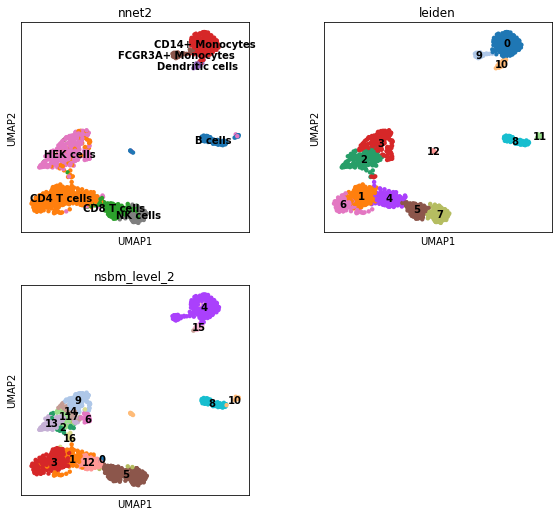

In [13]:
sc.pl.umap(adatae, color=['nnet2', 'leiden', 'nsbm_level_2'], ncols=2, legend_loc='on data')

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.tl.rank_genes_groups(adatae, groupby='nsbm_level_2', method='logreg')

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


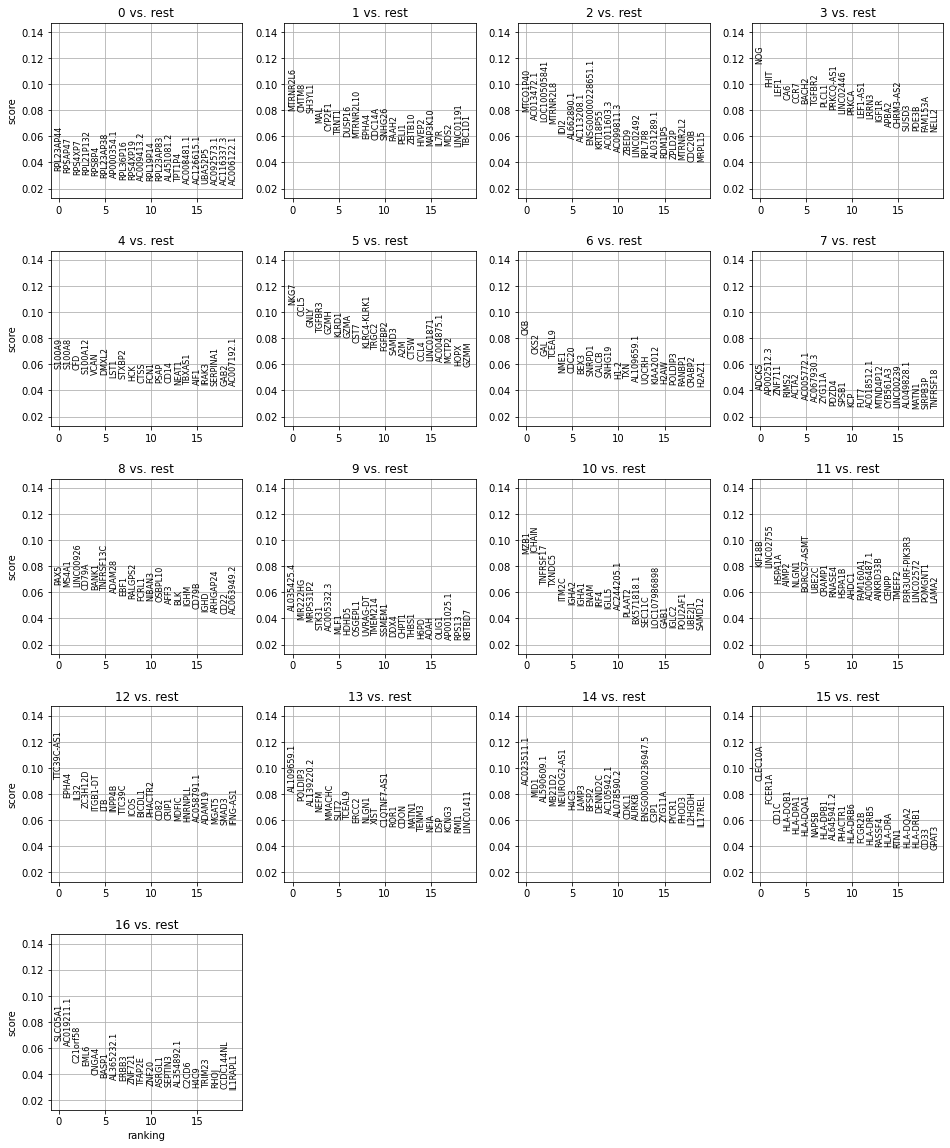

In [18]:
rcParams['figure.figsize'] = 4,4
rcParams['axes.grid'] = True
sc.pl.rank_genes_groups(adatae)

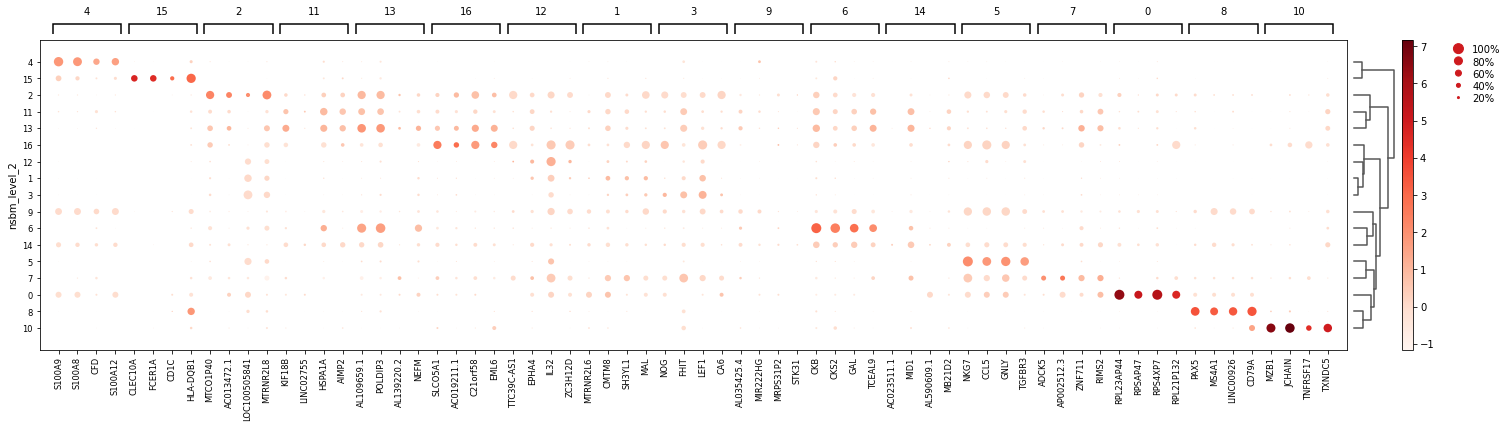

In [19]:
sc.pl.rank_genes_groups_dotplot(adatae, n_genes=4)

# Equilibrate false

In [33]:
scnsbm.inference.nested_model(adata, random_seed=42, equilibrate=False, steps_anneal=3, n_init=3)

minimizing the nested Stochastic Block Model
    done (0:04:14)
    calculating cell affinity to groups
    finished (0:04:17)


In [34]:
scnsbm.io.write(adata, prefix='10XV3')

In [35]:
adata=sc.read('10XV3.h5ad')
astate=pickle.load(open('10XV3.pkl','rb'))

In [36]:
adata.write('state_adata/10XV3_minimize.h5ad')
pickle.dump(astate,open('state_adata/10XV3_minimize.pkl','wb'),2)

In [3]:
adatam=sc.read('state_adata/10XV3_minimize.h5ad')
mstate=pickle.load(open('state_adata/10XV3_minimize.pkl','rb'))

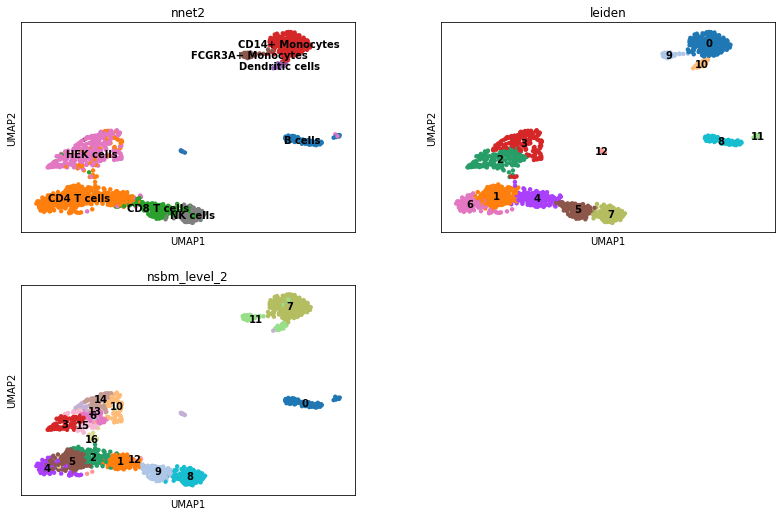

In [5]:
sc.pl.umap(adatam, color=['nnet2', 'leiden', 'nsbm_level_2'], ncols=2, legend_loc='on data')

# PAGA

paga leiden


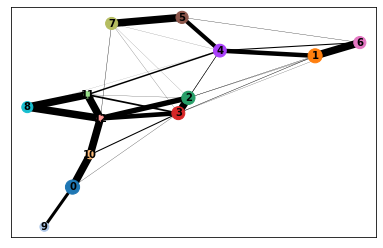

paga nsbm


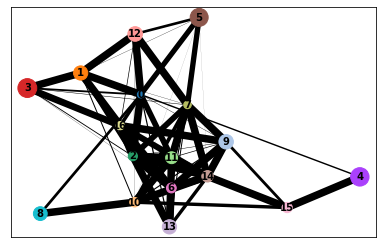

paga nnet2


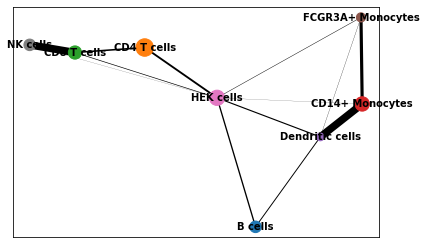

In [4]:
print('paga leiden')
sc.tl.paga(adatae,groups='leiden')
sc.pl.paga(adatae, color=['leiden'])
print('paga nsbm')
sc.tl.paga(adatae,groups='nsbm_level_2')
sc.pl.paga(adatae, color=['nsbm_level_2'])
print('paga nnet2')
sc.tl.paga(adatae,groups='nnet2')
sc.pl.paga(adatae, color=['nnet2'])

paga leiden


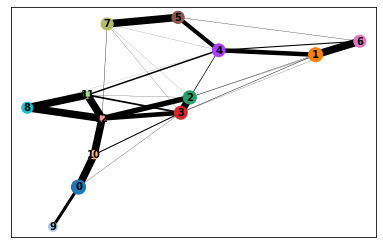

paga nsbm


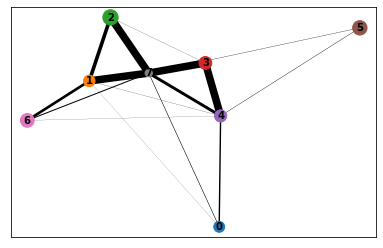

paga nnet2


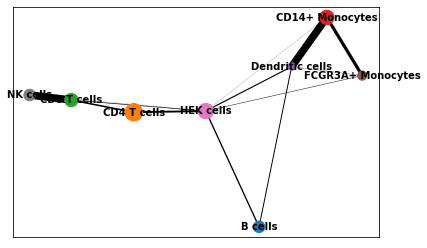

In [5]:
print('paga leiden')
sc.tl.paga(adatam,groups='leiden')
sc.pl.paga(adatam, color=['leiden'])
print('paga nsbm')
sc.tl.paga(adatam,groups='nsbm_level_3')
sc.pl.paga(adatam, color=['nsbm_level_3'])
print('paga nnet2')
sc.tl.paga(adatam,groups='nnet2')
sc.pl.paga(adatam, color=['nnet2'])

In [8]:
adatam.write('state_adata/10XV3_minimize.h5ad')
adatae.write('state_adata/10XV3_equilibrate.h5ad')

In [6]:
adatam=sc.read('state_adata/10XV3_minimize.h5ad')
adatae=sc.read('state_adata/10XV3_equilibrate.h5ad')

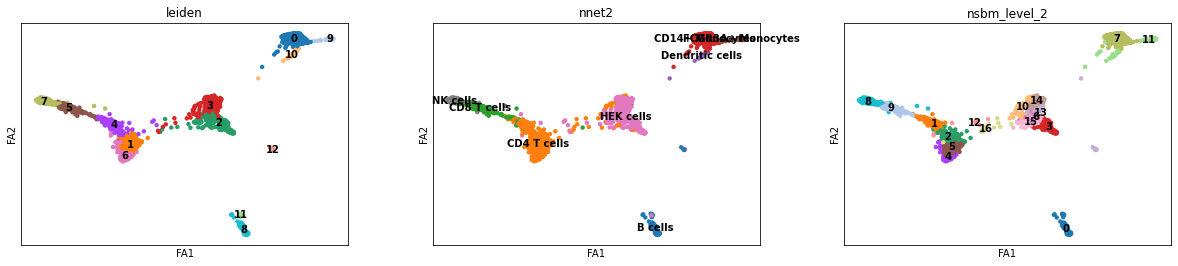

In [7]:
sc.tl.paga(adatam,groups='nnet2')
sc.tl.draw_graph(adatam, init_pos='paga')
sc.pl.draw_graph(adatam, color=['leiden', 'nnet2', 'nsbm_level_2'], legend_loc='on data')

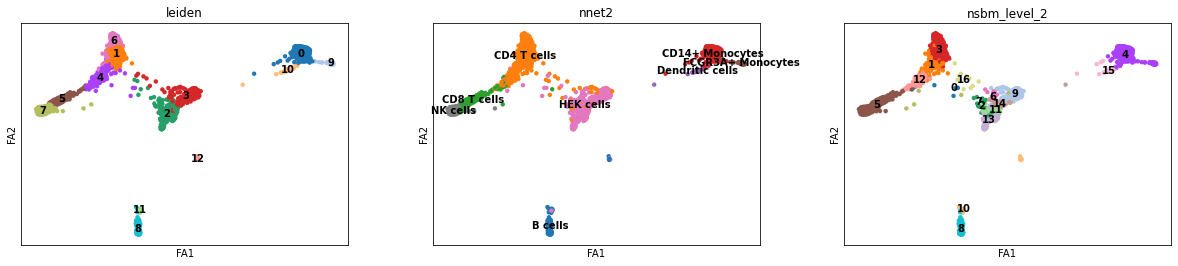

In [8]:
sc.tl.paga(adatae,groups='nnet2')
sc.tl.draw_graph(adatae, init_pos='paga')
sc.pl.draw_graph(adatae, color=['leiden', 'nnet2', 'nsbm_level_2'], legend_loc='on data')

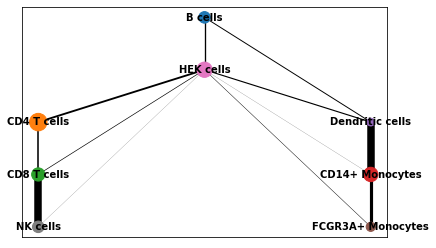

In [35]:
sc.pl.paga(adatam, color=['nnet2'], layout='eq_tree')

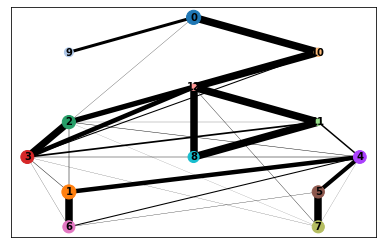

In [36]:
sc.tl.paga(adatam,groups='leiden')
sc.pl.paga(adatam, color=['leiden'], layout='eq_tree')

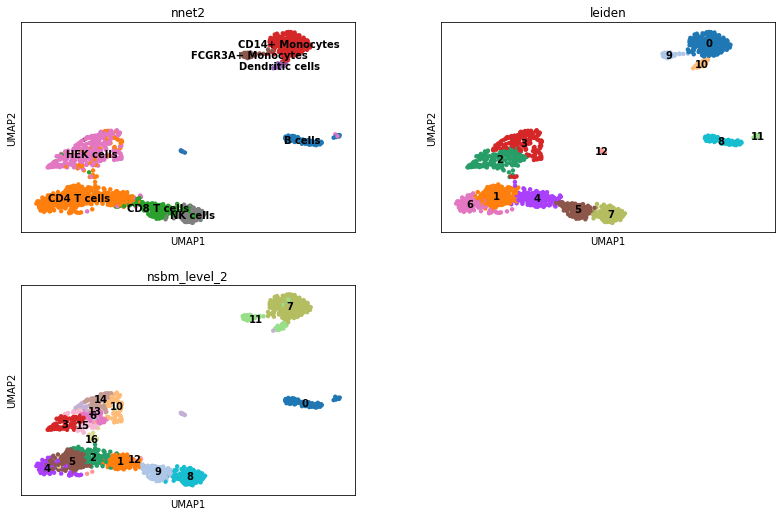

In [10]:
sc.pl.umap(adatam, color=['nnet2', 'leiden', 'nsbm_level_2'], ncols=2, legend_loc='on data')

In [9]:
M=adatam.uns['nsbm']['cell_affinity']['2']
adatam.obs['max_u'] = 1 - np.max(M, axis=1) 

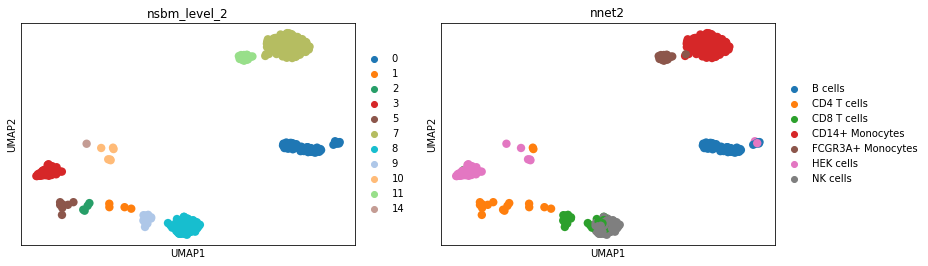

In [10]:
sc.pl.umap(adatam[adatam.obs.max_u < 1e-100], color=['nsbm_level_2','nnet2'])

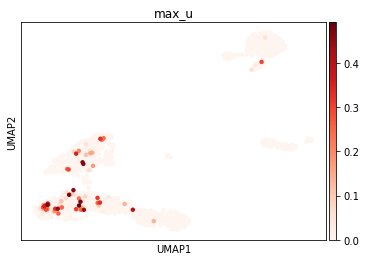

In [11]:
sc.pl.umap(adatam, color ='max_u',color_map='Reds')

In [27]:
E=adatae.uns['nsbm']['cell_affinity']['2']
adatae.obs['max_u'] = 1 - np.max(E, axis=1) 

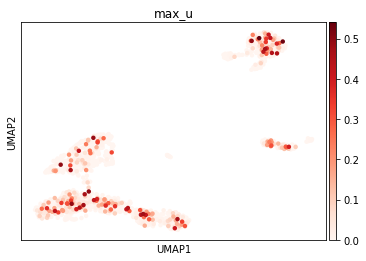

In [28]:
sc.pl.umap(adatae, color ='max_u',color_map='Reds')

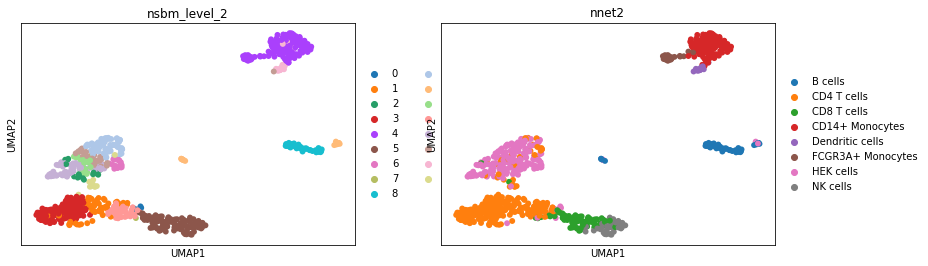

In [33]:
sc.pl.umap(adatae[adatae.obs.max_u < 1e-3], color=['nsbm_level_2','nnet2'])

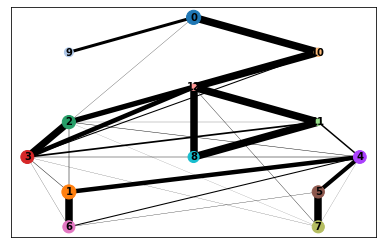

In [4]:
sc.tl.paga(adatam,groups='leiden')
sc.pl.paga(adatam, color=['leiden'], layout='eq_tree')

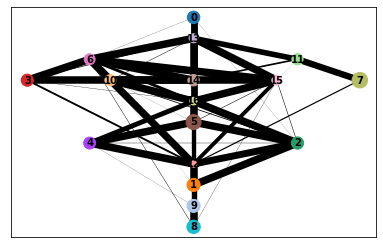

In [5]:
sc.tl.paga(adatam,groups='nsbm_level_2')
sc.pl.paga(adatam, color=['nsbm_level_2'], layout='eq_tree')

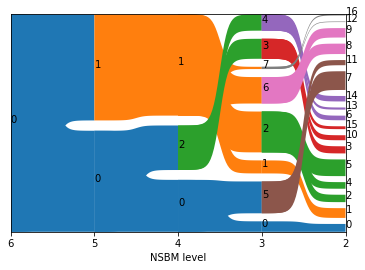

In [25]:
adatam = scnsbm.io.read('state_adata/10XV3_minimize')
scnsbm.pl.alluvial(adatam,level_end=6, level_start=2)

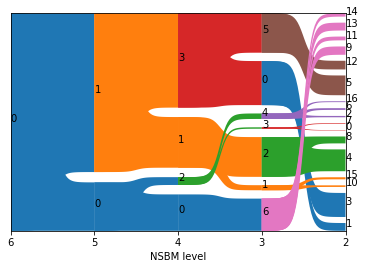

In [26]:
adatae = scnsbm.io.read('state_adata/10XV3_equilibrate')
scnsbm.pl.alluvial(adatae,level_end=6, level_start=2)
adatam = scnsbm.io.read('state_adata/10XV3_minimize')
scnsbm.pl.alluvial(adatam,level_end=6, level_start=2)

# Equilibrate 
### equilibrate 2

In [12]:
scnsbm.inference.nested_model(adata, random_seed=43, equilibrate=True, steps_anneal=3, n_init=3)

minimizing the nested Stochastic Block Model
    done (0:03:03)
running MCMC equilibration step
    calculating cell affinity to groups
    finished (0:40:55)


In [13]:
scnsbm.io.write(adata, prefix='10XV3')

In [14]:
adata=sc.read('10XV3.h5ad')
astate=pickle.load(open('10XV3.pkl','rb'))

In [15]:
adata.write('state_adata/10XV3_equilibrate2.h5ad')
pickle.dump(astate,open('state_adata/10XV3_equilibrate2.pkl','wb'),2)

In [16]:
adatae2=sc.read('state_adata/10XV3_equilibrate2.h5ad')
estate2=pickle.load(open('state_adata/10XV3_equilibrate2.pkl','rb'))

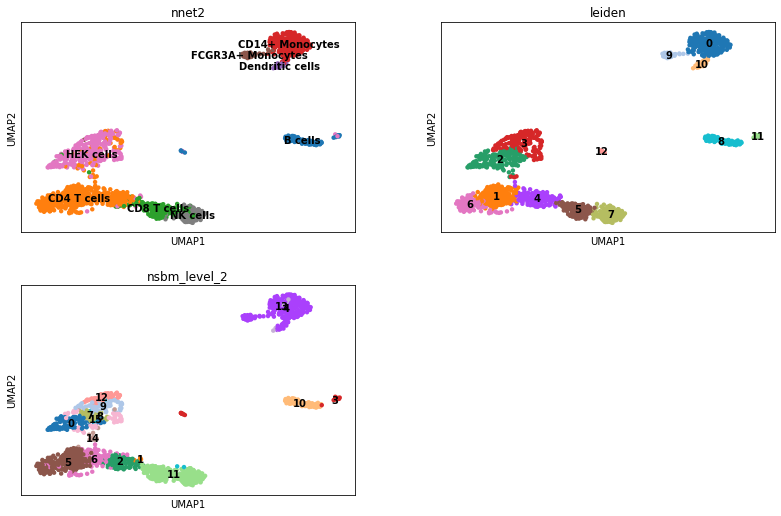

In [17]:
sc.pl.umap(adatae2, color=['nnet2', 'leiden', 'nsbm_level_2'], ncols=2, legend_loc='on data')

### equilibrate 3

In [29]:
scnsbm.inference.nested_model(adata, random_seed=44, equilibrate=True, steps_anneal=3, n_init=3)

minimizing the nested Stochastic Block Model
    done (0:03:40)
running MCMC equilibration step
    calculating cell affinity to groups
    finished (0:36:19)


In [30]:
scnsbm.io.write(adata, prefix='10XV3')

In [31]:
adata=sc.read('10XV3.h5ad')
astate=pickle.load(open('10XV3.pkl','rb'))

In [32]:
adata.write('state_adata/10XV3_equilibrate3.h5ad')
pickle.dump(astate,open('state_adata/10XV3_equilibrate3.pkl','wb'),2)

In [33]:
adatae3=sc.read('state_adata/10XV3_equilibrate3.h5ad')
estate3=pickle.load(open('state_adata/10XV3_equilibrate3.pkl','rb'))

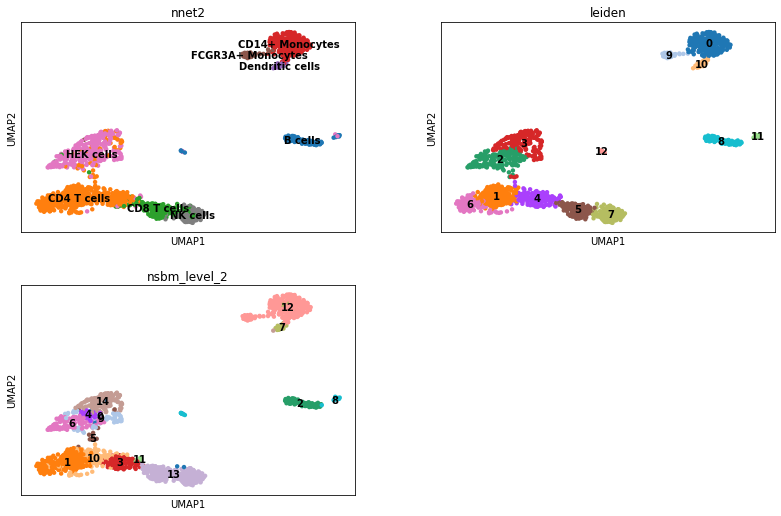

In [34]:
sc.pl.umap(adatae3, color=['nnet2', 'leiden', 'nsbm_level_2'], ncols=2, legend_loc='on data')

# Minimize
### minimize 2

In [47]:
scnsbm.inference.nested_model(adata, random_seed=43, equilibrate=False, steps_anneal=3, n_init=3)

minimizing the nested Stochastic Block Model
    done (0:03:06)
    calculating cell affinity to groups
    finished (0:03:09)


In [48]:
scnsbm.io.write(adata, prefix='10XV3')

In [49]:
adata=sc.read('10XV3.h5ad')
astate=pickle.load(open('10XV3.pkl','rb'))

In [50]:
adata.write('state_adata/10XV3_minimize2.h5ad')
pickle.dump(astate,open('state_adata/10XV3_minimize2.pkl','wb'),2)

In [51]:
adatam2=sc.read('state_adata/10XV3_minimize2.h5ad')
mstate2=pickle.load(open('state_adata/10XV3_minimize2.pkl','rb'))

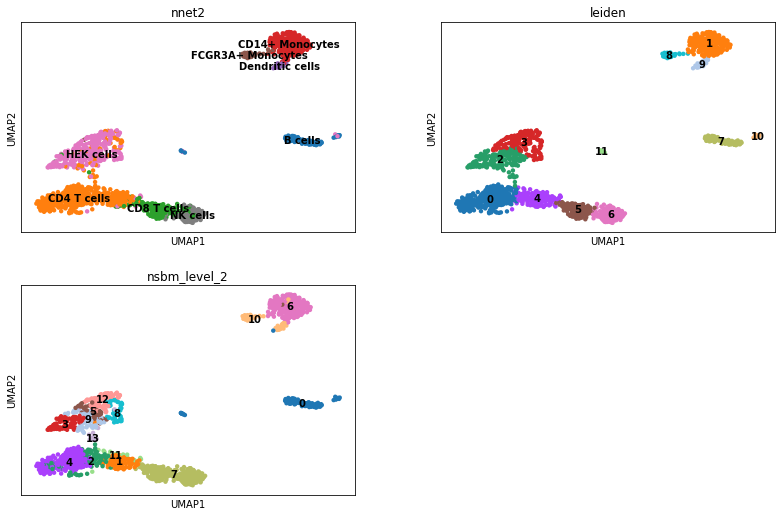

In [76]:
sc.pl.umap(adatam2, color=['nnet2', 'leiden', 'nsbm_level_2'], ncols=2, legend_loc='on data')

### minimize 3

In [64]:
scnsbm.inference.nested_model(adata, random_seed=44, equilibrate=False, steps_anneal=3, n_init=3)

minimizing the nested Stochastic Block Model
    done (0:07:41)
    calculating cell affinity to groups
    finished (0:07:44)


In [65]:
scnsbm.io.write(adata, prefix='10XV3')

In [66]:
adata=sc.read('10XV3.h5ad')
astate=pickle.load(open('10XV3.pkl','rb'))

In [67]:
adata.write('state_adata/10XV3_minimize3.h5ad')
pickle.dump(astate,open('state_adata/10XV3_minimize3.pkl','wb'),2)

In [68]:
adatam3=sc.read('state_adata/10XV3_minimize3.h5ad')
mstate3=pickle.load(open('state_adata/10XV3_minimize3.pkl','rb'))

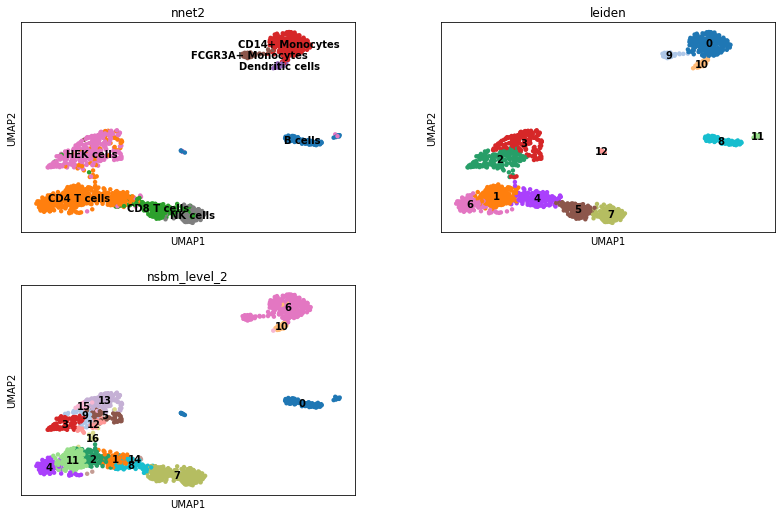

In [79]:
sc.pl.umap(adatam3, color=['nnet2', 'leiden', 'nsbm_level_2'], ncols=2, legend_loc='on data')